## 2D-3D registration

Setup: make sure python3.10 and virtualenv is installed. Then in the project folder, run:

```
python3.10 -m virtualenv venv-gsu
source venv-gsu/bin/activate
python -m pip install -r requirements.txt
git submodule update --init
```

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(linewidth=400)
from numpy.linalg import svd, norm, lstsq, inv, eigh, det, eigvalsh, eigvals
from tqdm.notebook import tqdm
from pathlib import Path
import time
import cv2

from matplotlib import pyplot as plt
%matplotlib widget

import scipy.optimize
from triangulation_relaxations import so3
from triangulation_relaxations.se3 import Se3
from triangulation_relaxations import geometry

from colmap.scripts.python.read_write_model import read_model, qvec2rotmat

## Load COLMAP data

Download a dataset from https://www.cs.ubc.ca/~kmyi/imw2020/data.html, example uses "Reichstag" which is the smallest one

In [2]:
def params_to_intrinsics(pars):
    return np.array([[pars[0], 0, pars[2]], [0, pars[1], pars[3]], [0, 0, 1]])

def get_intrinsics(camera):
    pars = camera.params
    if camera.model == 'SIMPLE_RADIAL':
        return np.array([
            [pars[0], 0, pars[1]],
            [0, pars[0], pars[2]],
            [0, 0, 1],
        ])
    else:
        return params_to_intrinsics(pars)

dataset = "reichstag"
src = Path(f'/mnt/c/Users/ktyyl/cop/jaxopt-3D-reconstruction/dataset/{dataset}/dense/sparse')
images_dir = Path(f'/mnt/c/Users/ktyyl/cop/jaxopt-3D-reconstruction/dataset/{dataset}/dense/images')

cameras, images, points = read_model(path=src, ext='.bin')

view_inds = sorted(images.keys())
point_inds = np.array(list(points.keys()))
intrinsics = np.array([get_intrinsics(cameras[images[i].camera_id]) for i in view_inds])
heights = [cameras[images[i].camera_id].height for i in view_inds]
widths = [cameras[images[i].camera_id].width for i in view_inds]

print(f'Cameras: {len(cameras)}')
print(f'Images: {len(images)}')
print(f'3D points: {len(points)}')

ydown2zup = np.array([
    [0, 0, 1, 0],
    [-1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, 0, 1]
])

# transform points to z-up convention
colmap_points = np.array([ydown2zup[:3, :3] @ point.xyz for point in points.values()])
colmap_colors = np.array([point.rgb / 255. for point in points.values()])

r = np.array([qvec2rotmat(images[i].qvec) for i in view_inds])
t = np.array([images[i].tvec for i in view_inds])

# transform poses to world-to-camera and z-up convention
colmap_poses = Se3(ydown2zup[:3, :3]) * Se3(r, t).inverse()

Cameras: 75
Images: 75
3D points: 17823


Text(0.5, 1.0, 'GT pose')

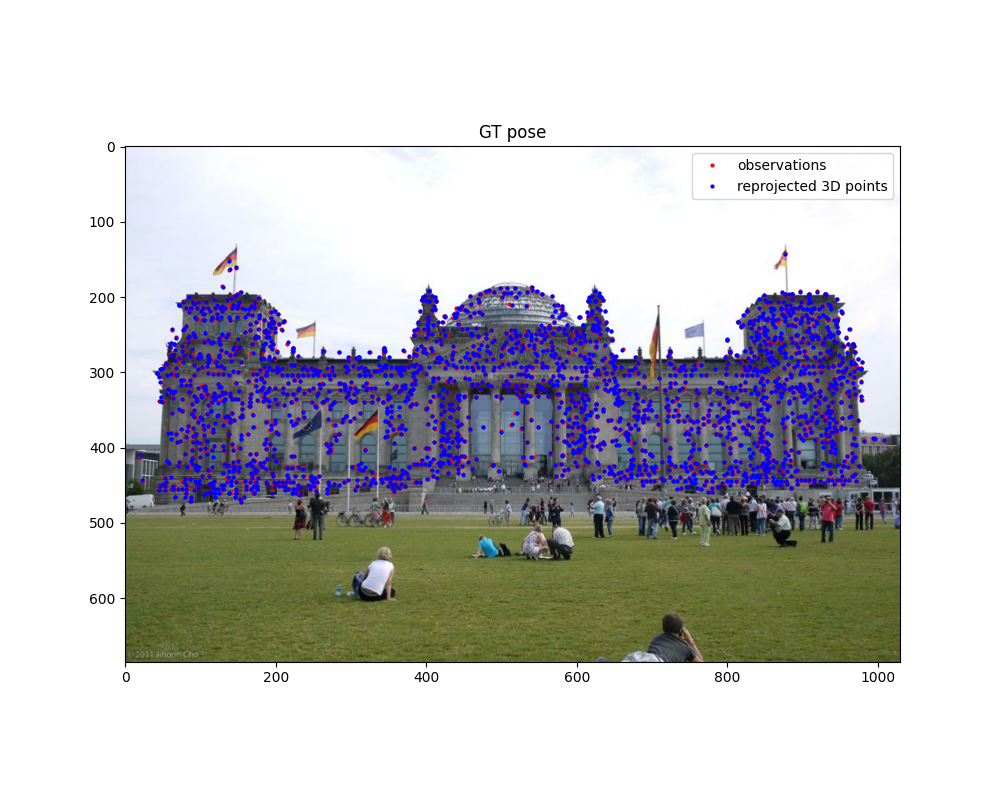

In [3]:
image_index = 2
image_id = view_inds[image_index]

observations = np.array([images[image_id].xys[i] for i, point_id in enumerate(images[image_id].point3D_ids) if point_id >= 0])

points_in_image = np.array([points[i].xyz for i in images[image_id].point3D_ids if i >= 0])
colors_in_image = np.array([points[i].rgb for i in images[image_id].point3D_ids if i >= 0]) / 255
points_3d = np.array([colmap_points[list(point_inds).index(i)] for i in images[image_id].point3D_ids if i >= 0])

reprojected_points = geometry.reproject(points_3d, colmap_poses[image_index], intrinsics[image_index])

image = cv2.imread(str(images_dir / images[image_id].name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.imshow(image)
ax.plot(observations[:, 0], observations[:, 1], 'o', color='red', markersize=2, label='observations')
ax.plot(reprojected_points[:, 0], reprojected_points[:, 1], 'o', color='blue', markersize=2, label='reprojected 3D points')
ax.legend()
ax.set_title('GT pose')

### Optimization example with Numpy/Scipy

In [4]:
import time

def x_to_pose(x):
    return Se3(so3.rotvec_to_r(x[:3]), x[3:])

def pose_to_x(pose):
    return np.concatenate([so3.r_to_rotvec(pose.R), pose.t])

def get_reprojection_residuals(pose, points, observations, intrinsics):
    reprojected_points = geometry.reproject(points, pose, intrinsics)
    return ((observations - reprojected_points) ** 2).sum(axis=1)

# Local optimization starting from another pose
pose0_index = 3
pose0 = colmap_poses[pose0_index]

def run_lm(_pose0):
    return scipy.optimize.least_squares(
        lambda x: get_reprojection_residuals(x_to_pose(x), points_3d, observations, intrinsics[image_index]),
        pose_to_x(_pose0),
        ftol=1e-15,
        gtol=1e-15,
        method='lm'
    ).x

start = time.process_time()
x = run_lm(pose0)
print(time.process_time() - start, "s elapsed")

pose_optimized = x_to_pose(x)
print(pose_optimized)

0.12609630000000038 s elapsed
R: [[-0.00555728 -0.02944488  0.99955096]
 [-0.99994755  0.00876351 -0.00530133]
 [-0.00860348 -0.99952799 -0.02949204]]
 t: [-0.84000345 -0.00264419  0.14835466]


In [18]:
import jax.numpy as jnp
from jax import vmap, device_put, jit
from jaxopt import GaussNewton, LevenbergMarquardt
import jax

@jit
def project_point_gpu(tree_arg):
    E, x, K = tree_arg
    return K @ E @ x


project_point_vmap = jit(vmap(project_point_gpu, in_axes=((None, 0, None),)))


@jit
def reproject_gpu(points: jnp.array, pose: jnp.array, K: jnp.array):
    x = project_point_vmap((jnp.linalg.inv(pose), points, K))
    x = x[..., :2] / x[..., 2:3]
    return x


@jit
def rotvec_to_r_gpu(rodrigues_vec):
    theta = jnp.linalg.norm(rodrigues_vec)
    r = rodrigues_vec / theta
    I = jnp.eye(3, dtype=float)
    r_rT = jnp.outer(r,r)
    r_cross = jnp.cross(jnp.eye(3), r)
    return jnp.cos(theta) * I + (1 - jnp.cos(theta)) * r_rT + jnp.sin(theta) * r_cross

@jit
def x_to_pose_gpu(x):
    R = rotvec_to_r_gpu(x[:3])
    return jnp.block([
        [R             , x[3:, jnp.newaxis]],
        [jnp.zeros(3).T, 1                 ]
    ])

def pose_to_x_gpu(pose):
    return jnp.concatenate([so3.r_to_rotvec(pose.R), pose.t])

_points_3d = np.concatenate([points_3d, np.ones((points_3d.shape[0],1))], axis=1)
points_gpu = device_put(_points_3d)
observations_gpu = device_put(observations)

_intrinsics = np.identity(4)
_intrinsics[:3,:3] = intrinsics[image_index]
intrinsics_gpu = device_put(_intrinsics)

@jit
def get_reprojection_residuals_gpu(pose, points, observations, intrinsics):
    reprojected_points = reproject_gpu(points, x_to_pose_gpu(pose), intrinsics)
    return ((observations - reprojected_points) ** 2).sum(axis=1)


lm = LevenbergMarquardt(
    residual_fun=get_reprojection_residuals_gpu,
    tol=1e-15,
    gtol=1e-15,
    jit=True,
    solver='inv'
)

jitted_lm = jit(lm.run)

def compile_lm(_pose0):
    _points_gpu = jnp.full_like(points_gpu, 0)
    _observations_gpu = jnp.full_like(observations_gpu, 0)
    _intrinsics_gpu = jnp.full_like(intrinsics_gpu, 0)
    jitted_lm(pose_to_x_gpu(_pose0),
              points=_points_gpu,
              observations=_observations_gpu,
              intrinsics=_intrinsics_gpu).params.block_until_ready()

def run_lm_gpu(_pose0):    
    return jitted_lm(pose_to_x_gpu(_pose0),
                     points=points_gpu,
                     observations=observations_gpu,
                     intrinsics=intrinsics_gpu).params

start = time.process_time()
compile_lm(pose0)
print("compilation time:", time.process_time() - start, "s")

start = time.process_time()
x_gpu = run_lm_gpu(pose0)
print("run time:", time.process_time() - start, "s")

pose_optimized_gpu = x_to_pose(np.array(x_gpu))

print(pose_optimized_gpu)

compilation time: 5.1110022000000015 s
run time: 0.11335890000000148 s
R: [[-0.00564957 -0.02932972  0.99955377]
 [-0.99994701  0.00876087 -0.00539462]
 [-0.00859883 -0.99953134 -0.0293777 ]]
 t: [-0.8407484  -0.00160041  0.14713661]


  0%|          | 0/102 [00:00<?, ?it/s]

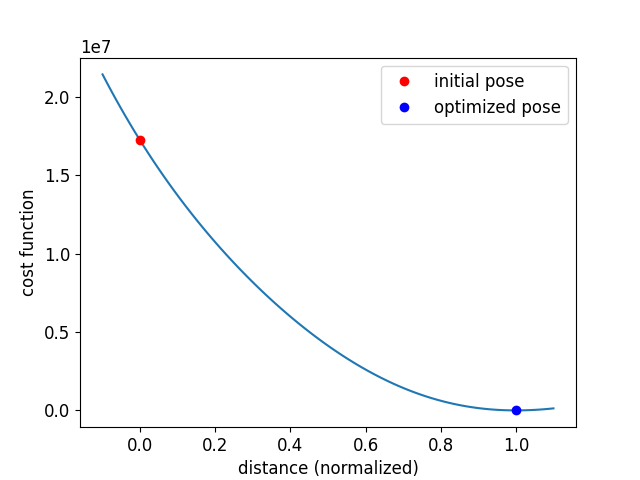

In [6]:
def plot_costs(ax, pose0, pose1, points, observations, intrinsics, eps=0.1, n=1000, label0='', label1=''):
    """Plot cost function when interpolating between pose0 and pose1"""
    taus = np.linspace(-eps, 1 + eps, n)
    index_0, index_1 = np.searchsorted(taus, [0, 1])
    taus = np.insert(taus, [index_0, index_1], [0, 1])
    index_1 += 1 # compensate for the insertion of 0

    objective_values = [
        get_reprojection_residuals(
            pose=Se3( # interpolate with axis-angle
                (pose0.q ** (1 - tau) * pose1.q ** tau).R,
                pose0.t * (1 - tau) + pose1.t * tau
            ),
            points=points,
            observations=observations,
            intrinsics=intrinsics,
        ).sum()
        for tau in tqdm(taus)
    ]
    ax.plot(taus, objective_values)
    ax.plot(0, objective_values[index_0], 'o', color='red', label=label0)
    ax.plot(1, objective_values[index_1], 'o', color='blue', label=label1)

# increase plot font size
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1, 1)
plot_costs(ax, pose0, pose_optimized_gpu, points_3d, observations, intrinsics[image_index], label0='initial pose', label1='optimized pose', n=100)
# ax.axhline(results_gt.cost, color='k', linestyle='--')
ax.set_xlabel('distance (normalized)')
ax.set_ylabel('cost function')
ax.legend()

Text(0.5, 1.0, 'Optimized pose')

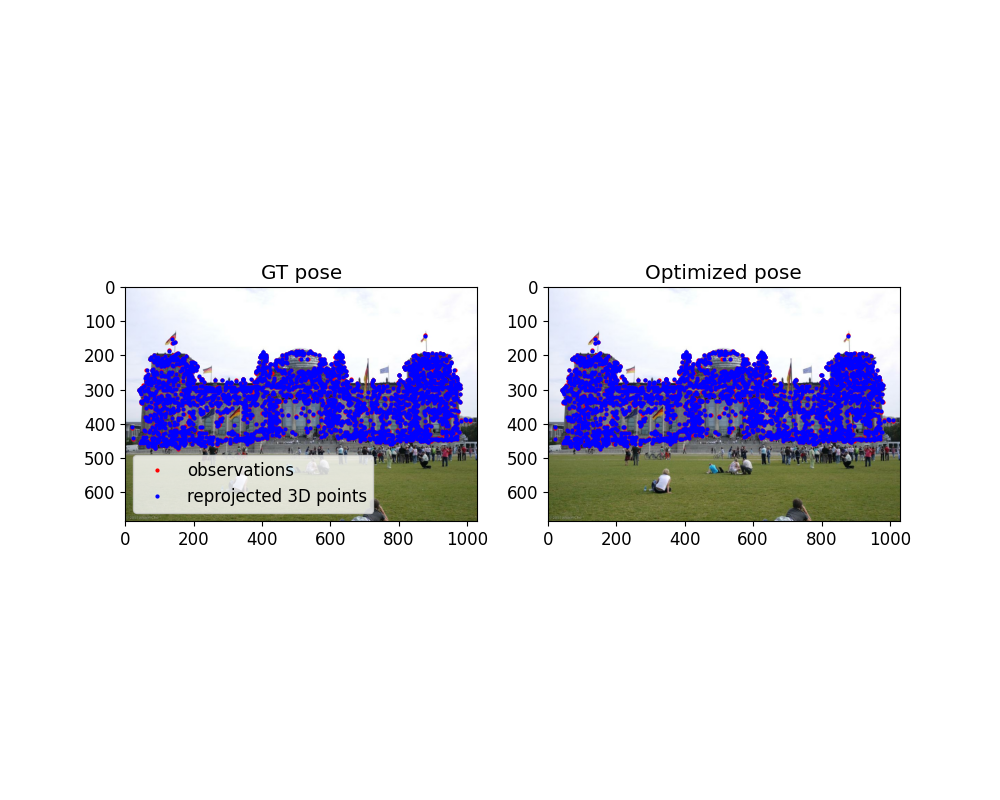

In [7]:
import cv2
reprojected_points = geometry.reproject(points_3d, colmap_poses[image_index], intrinsics[image_index])
optimized_reprojected_points = geometry.reproject(points_3d, pose_optimized_gpu, intrinsics[image_index])

image = cv2.imread(str(images_dir / images[image_id].name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].imshow(image)
ax[0].plot(observations[:, 0], observations[:, 1], 'o', color='red', markersize=2, label='observations')
ax[0].plot(reprojected_points[:, 0], reprojected_points[:, 1], 'o', color='blue', markersize=2, label='reprojected 3D points')
ax[0].legend()
ax[0].set_title('GT pose')

ax[1].imshow(image)
ax[1].plot(observations[:, 0], observations[:, 1], 'o', color='red', markersize=2, label='observations')
ax[1].plot(optimized_reprojected_points[:, 0], optimized_reprojected_points[:, 1], 'o', color='blue', markersize=2, label='reprojected 3D points')
ax[1].set_title('Optimized pose')